In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

DEFINING OBJECT TYPES TO SAVE SPACE 

In [2]:
#dtypes not nessecary for every file but these have helped immensley 
Movie_Financials_dtypes = {'Unnamed: 0':  int, 'tconst' :str , 'P_Cost':int , 'Dom_Gross':int , 
                   'Frgn_Gross':int, 'WW_Gross':int, 'Domestic Opening':int}
Generes_tconst_dtypes = {'Unnamed: 0':int, 'tconst':str, 'titleType':str, 'primaryTitle':str, 'originalTitle':str, 'startYear':int, 
                   'runtimeMinutes':int, 'genres':str, 'averageRating':float, 'numVotes':int, 'Splitgeneres':str}


movie_gross_dtype = {'title':str, 'studio':str, 'foreign_gross':str, 'year':str}
name_basics_dtype = {'nconst':str, 'primary_name':str, 'birth_year':str, 'death_year':str, 'primary_profession':str, 
                 'known_for_titles':str}
title_akas_dtype = {'title_id':str, 'ordering':int, 'title':str, 'region':str, 'language':str, 'types':str, 'attributes':str, 
                 'is_original_title':str}
title_basics_dtype = {'tconst':str, 'primary_title':str, 'original_title':str, 'start_year':str, 'genres':str}
title_crew_dtype = {'tconst':str, 'directors':str, 'writers':str}
title_principals_dtype = {'tconst':str, 'ordering':int, 'nconst':str, 'category':str, 'job':str, 'characters':str}
title_ratings_dtype = {'tconst':str, 'averagerating':float, 'numvotes':int}
tmdb_movies_dtype = {'Unnamed: 0':int, 'genre_ids':str, 'id':int, 'original_language':str, 'original_title':str, 
                 'popularity':float, 'release_date': str, 'title':str, 'vote_average':float, 'vote_count':int}

LOADING 
<p> Using Pandas to load all of our data </p>

In [3]:
#CSV files from Flatiron 
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz', dtype = movie_gross_dtype)
name_basics = pd.read_csv('zippedData/imdb.name.basics.csv.gz', dtype = name_basics_dtype)
title_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz', dtype = title_akas_dtype)
title_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz',dtype = title_basics_dtype)
title_crew = pd.read_csv('zippedData/imdb.title.crew.csv.gz', dtype = title_crew_dtype)
title_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz', dtype = title_principals_dtype)
title_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', dtype = title_ratings_dtype)
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', dtype = tmdb_movies_dtype)

In [4]:
#TSV FILES from FlatIron 
movie_info= pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t',encoding='utf-8')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t',encoding='unicode_escape')

In [5]:
#RUSS MASTER DATA
Generes_tconst = pd.read_excel('zippedData/df_Generes_With_tconst.xlsx')
Movie_Financials = pd.read_excel('zippedData/df_Movie_Financials.xlsx',  dtype = Movie_Financials_dtypes)

In [6]:
#ROTTEN TOMATOES DATA DOWNLOADED FROM THE WEB 
rottendata = pd.read_csv('zippedData/all_movie.csv')

CLEANING UP THE DATA 
<p> Dropping columns that don't have relevant/complete enough data, filling other columns with average values or placeholders</p>

In [7]:
#keeping non-numeric columns with few NaN values so we could still use 
#to groupby or search from, can always drop later subbing for unknown 
#so we don't get and NaN errors & can still drop later

movie_info['rating'] = movie_info['rating'].rename('parent_rating', inplace=True) #name slightly misleading 

gross = movie_gross.drop(labels='domestic_gross', axis=1).copy()
#russ scraped better domestic gross data, use that instead

names = name_basics.drop(labels='birth_year', axis=1).drop(labels='death_year', axis=1).fillna('unknown')
# we can't birth nor kill a director so not sure if that'll help more than hurt

fi_akas = title_akas.drop(labels='attributes', axis=1).drop(labels='language', axis=1).drop(labels='types', axis=1).fillna('unknown')
#not complete/not relevant after exploring

basics = title_basics.fillna(title_basics['runtime_minutes'].median()).fillna('unknown')
crew = title_crew.fillna('unknown')
principals = title_principals.drop(labels='job', axis=1).drop(labels='characters', axis=1)

#numvotes range wildly making votes less accurate if not sorted to be in certain thresholds 
tmdb_movies = tmdb_movies.drop(labels='Unnamed: 0', axis=1).drop(labels='popularity', axis=1)

#columns full but useless 
rt_reviews = rt_reviews.drop(labels='rating', axis=1).fillna('unknown')

#rating probably not worth trying to add, would have to convert a lot to determine mean/med/mode
#use IMBD for audience response RT for critic 
#review subbed for unknown so we could still use to search 

Look through your data and check that everything lines up correctly, that you don't have any NaN values,  read the reviews and make sure they match the titles, google the years things came out, etc. You don't need to look at *every* piece of data but be sure to periodically check and make sure nothing is out of place. 

COMBINING DATA 
<p> Merging dataframes into more complete information that's easier to acess </p>

In [8]:
#compiling my rotten tomatoes data into the main 2 dataframes I'll be using for reviews 
box_vs_rate = rt_reviews.merge(movie_info, how='inner', on='id')
full_rotten = box_vs_rate.merge(rottendata, how='inner', left_on='synopsis', right_on='Description')

In [9]:
#playing around to find the largest dataframe that could help connect everything, things do line up correctly
# but there are more gaps 

fi_master = gross.merge(fi_akas, how='outer', on='title').merge(tmdb_movies,  how='outer', on='title')
fi_master = fi_master.merge(basics, how='outer', on='original_title').merge(crew, how='outer', on='tconst')
fi_master = fi_master.merge(principals, how='outer', on='tconst').merge(names, how='outer', on='nconst')
fi_master = fi_master.sort_values(by='title_id', ascending=False)

mini_master = fi_master[['title', 'studio', 'year', 'original_language','original_title', 'release_date', 'vote_average', 
                         'vote_count', 'runtime_minutes', 'genres', 'directors', 'writers', 'id', 'tconst']].dropna().copy()
mini_master = mini_master.merge(rt_reviews, how='inner', on='id')

STARTING MY ANALYSIS AND FINDING WHAT DATA IM GOING TO BE FOCUSING ON FOR THE FIRST VISUAL 
<p> Making new dataframes only containing information pertaining to the visual we're creating </p>

In [10]:
#breaking down my rotten tomatoes data into smaller dataframes that give me better access to the data I need from them 

rotten1 = full_rotten.merge(rt_reviews, on='id')
rotten1['id'].fillna(0, inplace=True)
movie_info['id'].fillna(0, inplace=True)
tmdb_moviesnoid = tmdb_movies.drop(labels='id', axis=1)

rotten2 = rotten1.merge(movie_info, how='outer', on='id')

criticrev = rotten1.loc[rotten1['fresh_y'] == 'fresh'].copy()
crticcounts = criticrev['Genre'].value_counts()
criticgenres = crticcounts.to_frame()

fresh_count = rotten1[['publisher_y', 'fresh_y']].sort_values(by='publisher_y').dropna().copy().reset_index()
fresh_count = fresh_count.drop('index', axis=1)
fresh_count = fresh_count[fresh_count != 'NaN'] 

In [11]:
#focusing on critic reviews and getting them ready to plot, removing all columns not nessecary for visualizing 

criticsgrp = fresh_count.groupby(['publisher_y','fresh_y']).size()
criticsgrp = criticsgrp.to_frame(name='vs')
criticsgrp = criticsgrp.drop(labels='unknown', axis=0)

cgroup = fresh_count.groupby(['publisher_y']).size()
cgroup = cgroup.to_frame(name='vs')
cgroup = cgroup.drop(labels='unknown', axis=0)

# getting the top 100 publishers based on how many reviews they post 

manyreviews = cgroup.sort_values(by='vs', ascending=False).head(100)
manyreviews = manyreviews.reset_index()

In [12]:
#focusing on what genres critics are most interested in and removing all columns not nessecary for visualizing 

genre_ratings = rotten1[['publisher_y', 'Genre', 'fresh_y']].sort_values(by='publisher_y').dropna().copy().reset_index().drop('index', axis=1)
generes_sum = genre_ratings.groupby(['publisher_y', 'Genre'])['Genre'].count().to_frame(name='generes_sum')
generes_sum = generes_sum.drop(labels='unknown')
generes_sum = generes_sum.reset_index()

In [13]:
# by genre, beginning to break down how many of each publishers reviews were positive or negative 
fresh_sum = genre_ratings.groupby(['publisher_y', 'Genre', 'fresh_y'])['fresh_y'].count().to_frame()
fresh_sum['fresh'] = fresh_sum['fresh_y']
fresh_sum = fresh_sum.drop(columns='fresh_y')
fresh_sum = fresh_sum.reset_index()
notsofresh = fresh_sum[ fresh_sum['fresh_y'] == 'rotten' ].index 
fresh_sum.drop(notsofresh, inplace = True) 

In [14]:
#generating percentage of positive and negative reviews 
pubsgeneres = fresh_sum.merge(generes_sum)
pubsgeneres['% Positive'] = pubsgeneres['fresh']/pubsgeneres['generes_sum'] *100

GETTING READY TO PLOT 
<p> Make sure your index is set to the correct values, if you have multiple plots, try and make sure they line up in a way that works visually</p>

In [15]:
# making each genre easier to plot, cleaning up unnessecary columns 
pubsgeneres = pubsgeneres.drop('fresh', axis=1)
pubsgeneres = pubsgeneres.drop('fresh_y', axis=1)
pubsgeneres['generes_sum'] = pubsgeneres['generes_sum']/100
pubsgeneres['Total_Reviews'] = pubsgeneres['generes_sum'] 
pubsgeneres = pubsgeneres.set_index('publisher_y')
pubsgeneres.drop('generes_sum', axis=1, inplace=True)

In [16]:
#getting a list of all the top genres 
l = 0 

Genres = []

for genre in generes_sum['Genre']:
    Genres.append(generes_sum['Genre'][l])
    l += 1 
    
Genres = set(Genres)

In [17]:
# making lists to find the top pushiers and what percentage of their reviews were positive 

i = 0 
j = 0 

top50_pubs = []

for critic in manyreviews['publisher_y']:
    top50_pubs.append(manyreviews['publisher_y'][i])
    i += 1 
    

fresh = {}
rotten = {}

for critic in top50_pubs:
    fresh.update({ j : int(str(criticsgrp.loc[top50_pubs[j]].iloc[0]).split(' ')[4].strip('\nName:'))})
    rotten.update({ j : int(str(criticsgrp.loc[top50_pubs[j]].iloc[1]).split(' ')[4].strip('\nName:'))})
    j += 1     

freshdf = pd.DataFrame(fresh.values(), columns=['fresh'])
rottendf = pd.DataFrame(fresh.values(), columns=['fresh'])

In [18]:
# combining the data we'd prepared on critics and the data we'd prepared 

criticbreakdown = manyreviews.merge(freshdf, left_index=True, right_index=True).copy()
criticbreakdown['rotten'] = criticbreakdown['vs'] - criticbreakdown['fresh'] 
criticbreakdown.rename(columns={'vs' : 'total'}, inplace=True)

criticbreakdown = criticbreakdown.sort_values(by='total', ascending=False).reset_index()
criticbreakdown['most_reviews'] = criticbreakdown['index']#.rename('most_reviews')

criticbreakdown['%_positive'] = criticbreakdown['fresh'] / criticbreakdown['total'] *100
criticbreakdown['%_negative'] = criticbreakdown['rotten'] / criticbreakdown['total'] *100

criticbreakdown.drop(labels='index', axis=1, inplace=True)

In [19]:
# getting everything in units the will line up with lineplot 
critvis = criticbreakdown.sort_values(by='most_reviews', ascending=True).head(50)
critvis['fresh'] = critvis['fresh']/1000
critvis['rotten'] = critvis['rotten']/1000
cc = critvis[['fresh', 'rotten', 'publisher_y']]
ccc = critvis[['publisher_y', '%_positive']]
#c = c.sort_values(by='most_reviews', ascending=False).head(5)
criticongenre = criticbreakdown.merge(generes_sum)

CREATING THE TOMATO PLOT!
<p> Using matplotlib to create a stacked bar chart with a dashed line chart laying over it, and a highlighting box</p> 

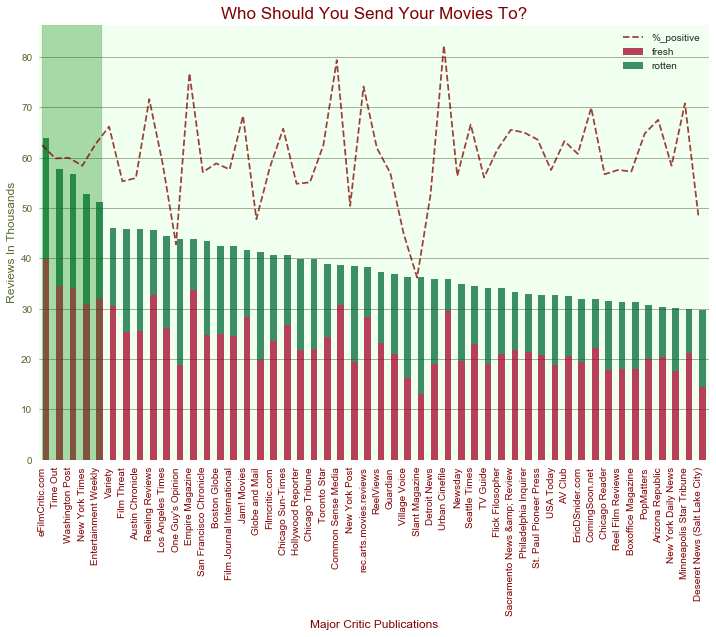

In [20]:
#creating the tomato plot! 

mpl.style.use('seaborn') 
ccplot = ccc.plot(kind='line',  x='publisher_y', figsize=(12,8), color='maroon', linestyle='dashed', linewidth=1.75, alpha=.75)
cplot = cc.plot(kind='bar', x='publisher_y', figsize=(12,8), position=-0.1, stacked=True, colormap='RdYlGn', ax=ccplot, alpha=.75)

x = np.linspace(0, 1*np.pi, 100)
y = np.sin(x)

cplot.plot(x, y, 'k-', lw=0)
cplot.axvspan(0.0, 4.5, color='g', alpha=0.3)

#mask = (x > 2.5) & (x < 3.0)
#cplot.plot(x[mask], y[mask], 'r-', lw=2.5)


cplot.set_title('Who Should You Send Your Movies To?'.format('seaborn'), color='maroon', fontsize=17)
cplot.set_xlabel(xlabel='Major Critic Publications' .format('seaborn'), color='maroon', fontsize=12)
#cplot.set_xticks(ticks[])
cplot.set_ylabel(ylabel='Reviews In Thousands'.format('seaborn'), color='darkolivegreen', fontsize=12)
cplot.set_facecolor(color='honeydew')
cplot.axes.yaxis.grid(b=True, which='Both', color='darkolivegreen', linestyle='-', linewidth=.5)
cplot.axes.xaxis.grid(b=False)

cplot.spines['bottom'].set_color('red')
cplot.spines['top'].set_color('red')

cplot.tick_params(axis='x', colors='maroon')
cplot.tick_params(axis='y', colors='darkolivegreen')

plt.show()

STARTING THE SECOND VISUAL
<p>analyzing financial and audience data for next visual </p>

In [21]:
#goal is to find out if critics have any sway on success 
sway = Movie_Financials.merge(Generes_tconst, on='tconst')
sway = rotten1.merge(sway, left_on='Title', right_on='primaryTitle')
sway = sway.sort_values('numVotes')
sway = sway[['Title','P_Cost',  'WW_Gross', 'Domestic Opening', 'Rating', 'averageRating', 'numVotes', 'Runtime', 'fresh_y']].copy()

In [22]:
sway = sway.drop_duplicates(subset='Title')
sway['ROI'] = sway['P_Cost'] / sway['WW_Gross'] * 100

In [23]:
# for movies under 5 stars, how many votes did they get? 
#Out of all of the bad movies, did critic reviews leave bad movies more popular?
# creating dictionaries to hold data 

criticreq = {}
criticmon = {}

In [24]:
#gathering all of the rotten movies into one data frame 
rott = sway.loc[sway['fresh_y'] == 'rotten']
rott = rott.sort_values('numVotes', ascending=False).head(50)
rottvotes = rott['numVotes'].sum() / 50
rottnums = rott['ROI'].sum() / 100 
rottvotesdisliked = int(rottvotes.round())
rottROIdisliked = int(rottnums.round())
criticreq.update({'Populararity of Movies Disliked By Critics': rottvotesdisliked})
criticmon.update({'ROI of Movies Disliked By Critics': rottROIdisliked})

In [25]:
#gathering all of the bad movies into one data frame 
bad = sway.loc[sway['averageRating'] <= 5 ]
bad = bad.sort_values('numVotes', ascending=False).head(100)
badvotes = bad['numVotes'].sum() / 100
badnums = bad['ROI'].sum() / 100 
badvotesdisliked = int(badvotes.round())
badROIdisliked = int(badnums.round())
criticreq.update({'Populararity of Movies Disliked By Audiences': badvotesdisliked})
criticmon.update({'ROI of Movies Disliked By Audiences': badROIdisliked})

In [26]:
#gathering all of the fresh movies into one data frame 
fresh = sway.loc[sway['fresh_y'] == 'fresh']
fresh = fresh.sort_values('numVotes', ascending=False).head(100)
freshvotes = fresh['numVotes'].sum() / 100
freshnums = fresh['ROI'].sum() / 100 
freshvotesliked = int(freshvotes.round(0))
freshROIliked = int(freshnums.round(0))
criticreq.update({'Populararity of Movies Liked By Critics': freshvotesliked})
criticmon.update({'ROI of Movies Liked By Critics': freshROIliked})

In [27]:
#gathering all of the good movies into one data frame 
good = sway.loc[sway['averageRating'] >= 5 ]
good = good.sort_values('numVotes', ascending=False).head(100)
goodvotes = good['numVotes'].sum() / 100
goodnums = good['ROI'].sum() / 100 
goodvotesliked = int(goodvotes.round())
goodROIliked = int(goodnums.round())
criticreq.update({'Populararity of Movies Liked By Audiences': goodvotesliked})
criticmon.update({'ROI of Movies Liked By Audiences': goodROIliked})

In [28]:
#setting both of our dictionaries to dataframes
criticreqdf = pd.DataFrame.from_dict(criticreq, orient='index')
criticmondf = pd.DataFrame.from_dict(criticmon, orient='index')

In [29]:
#making sure they stay in the same order 
criticreqdf = criticreqdf.sort_index()
criticmondf = criticmondf.sort_index()

In [30]:
#making the index a column we can call upon as our 'y'
criticmondf.reset_index(inplace=True)
criticreqdf.reset_index(inplace=True)

PLOTTING THE SECOND GRAPHS
<p> With your data formatted properly, using seaborn to plot is a breeze</p>

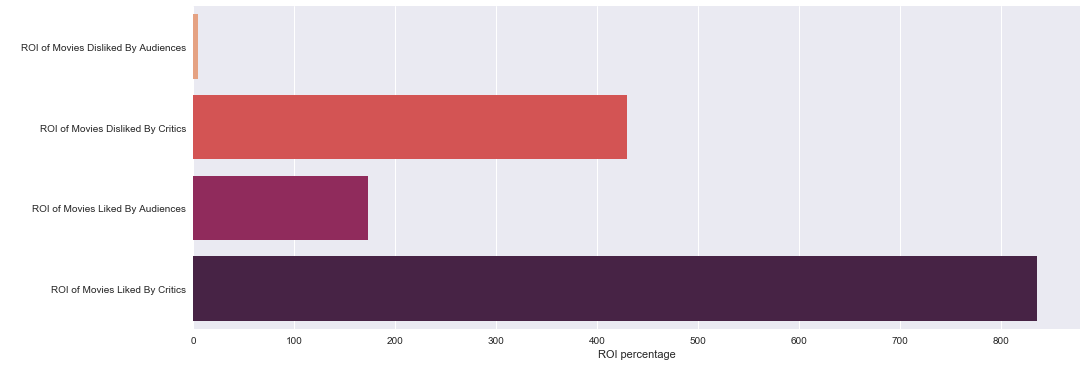

In [31]:
mon = sns.catplot(kind='bar', x=0, y='index', data=criticmondf, height=5, aspect=3, palette='rocket_r')
mon.set(xlabel="ROI percentage", ylabel = " ")  

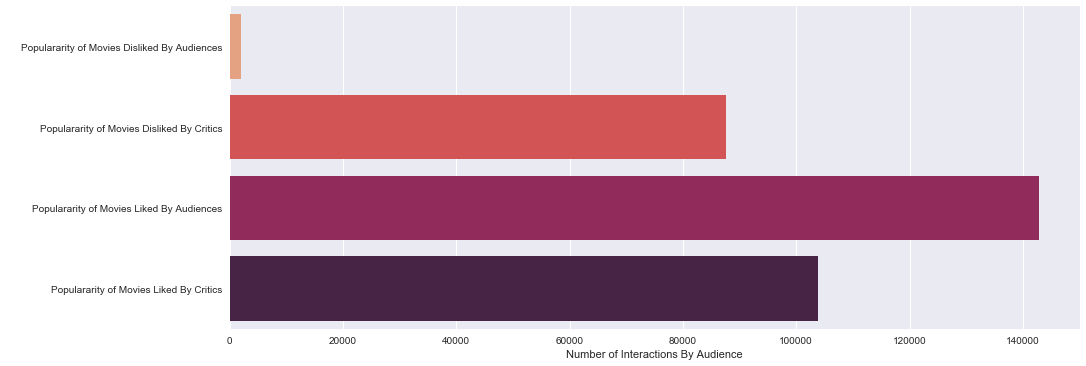

In [32]:
req = sns.catplot(kind='bar', x=0, y='index', data=criticreqdf, height=5, aspect=3, palette='rocket_r')
req.set(xlabel="Number of Interactions By Audience", ylabel = " ")